In [1]:
import gym
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from lib import plotting
import time

from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
env.observation_space.sample()

array([-0.6810389 , -0.75131524,  0.12553263, -0.13899499, -0.83103967,
       22.193163  ], dtype=float32)

In [4]:
class TileCoder:
    
    def __init__(self, tiles_per_dim, value_limits, tilings, offset=lambda n: 2 * np.arange(n) + 1):
        tiling_dims = np.array(np.ceil(tiles_per_dim), dtype=np.int) + 1
        self._offsets = offset(len(tiles_per_dim)) * \
          np.repeat([np.arange(tilings)], len(tiles_per_dim), 0).T / float(tilings) % 1
        self._limits = np.array(value_limits)
        self._norm_dims = np.array(tiles_per_dim) / (self._limits[:, 1] - self._limits[:, 0])
        self._tile_base_ind = np.prod(tiling_dims) * np.arange(tilings)
        self._hash_vec = np.array([np.prod(tiling_dims[0:i]) for i in range(len(tiles_per_dim))])
        self._n_tiles = tilings * np.prod(tiling_dims)
  
    def __getitem__(self, x):
        off_coords = ((x - self._limits[:, 0]) * self._norm_dims + self._offsets).astype(int)
        return self._tile_base_ind + np.dot(off_coords, self._hash_vec)

    @property
    def n_tiles(self):
        return self._n_tiles

In [37]:
tiles_per_dim = [10, 10]
# value limits of each dimension
lims = [(0.0, 10.0), (0.0, 10.0)]
# number of tilings
tilings = 20
T = TileCoder(tiles_per_dim, lims, tilings)
T[3.6, 7.21]

array([  80,  201,  322,  443,  564,  685,  817,  927, 1049, 1170, 1291,
       1412, 1544, 1665, 1775, 1896, 2017, 2138, 2259, 2391])

In [55]:
test = np.array([3.6, 7.21])

In [56]:
T[test]

array([  80,  201,  322,  443,  564,  685,  817,  927, 1049, 1170, 1291,
       1412, 1544, 1665, 1775, 1896, 2017, 2138, 2259, 2391])

In [46]:
# target function with gaussian noise
def target_ftn(x, y):
    return np.sin(x) + np.cos(y) + 0.05 * np.random.randn()

# linear function weight vector, step size for SGD
w = np.zeros(T.n_tiles)
alpha = 0.1 / tilings

# take 10,000 samples of target function, output mse of batches of 100 points
timer = time.time()
batch_size = 100
for batches in range(1000):
    mse = 0.0
    for b in range(batch_size):
        x = lims[0][0] + np.random.rand() * (lims[0][1] - lims[0][0])
        y = lims[1][0] + np.random.rand() * (lims[1][1] - lims[1][0])
        target = target_ftn(x, y)
        tiles = T[x, y]
        w[tiles] += alpha * (target - w[tiles].sum())
        mse += (target - w[tiles].sum()) ** 2
    mse /= batch_size
print('samples:', (batches + 1) * batch_size, 'batch_mse:', mse)
print('elapsed time:', time.time() - timer)


samples: 100000 batch_mse: 0.0020057503906974693
elapsed time: 2.3743462562561035


In [47]:
tiles = T[2.5, 3.1]
w[tiles].sum()

-0.4152506535677165

In [25]:
np.sin(2.5)+np.cos(3.1)

-0.40066300616932293

In [36]:
class Function_Approximator():
    
    def __init__(self):
        tiles_per_dim = [2,2,2,2,8,18]
        lims = [(-1.0,1.0),(-1.0,1.0),(-1.0,1.0),(-1.0,1.0),(-4*np.pi,4*np.pi),(-9*np.pi,9*np.pi)]
        tilings = 8
        self.T = TileCoder(tiles_per_dim, lims, tilings)
        self.q0 = np.zeros(self.T.n_tiles)
        self.q1 = np.zeros(self.T.n_tiles)
        self.q2 = np.zeros(self.T.n_tiles)
        self.alpha_sgd = 0.1/tilings
        
    def predict(self,state):
        
        tiles = self.T[state]
        val_q0 = self.q0[tiles].sum()
        val_q1 = self.q1[tiles].sum()
        val_q2 = self.q2[tiles].sum()
        
        return np.array([val_q0,val_q1,val_q2])
    
    def update(self,state,action,target):
        
        tiles = self.T[state]
        if action == 0:
            self.q0[tiles] += self.alpha_sgd*(target-self.predict(state)[0])
        elif action == 1:
            self.q1[tiles] += self.alpha_sgd*(target-self.predict(state)[1])                                             
        elif action == 2:
            self.q2[tiles] += self.alpha_sgd*(target-self.predict(state)[2])        
        
        

In [40]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        #print(q_values)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [41]:
def sarsa(env, estimator, num_episodes, discount_factor=0.99, epsilon=0.1, epsilon_decay=1.0):
    
    alpha = 1
    
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Initialize 's'
        state = env.reset()
        
        # Choose 'a' and 's' using policy derived from Q
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
        for t in itertools.count():
            
            # Take action 'a' and observe r, s'
            next_state, reward, end, _ = env.step(action)
            env.render()
            
            # Choose a' from s' using policy derived from Q
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Get Q(s,~)
            q_values_this = estimator.predict(state)
            
            # Get Q(s',~)
            q_values_next = estimator.predict(next_state)
            
            # [r + gamma*Q(s',a')]
            td_target = alpha*(reward + discount_factor * q_values_next[next_action]) + (1-alpha)*q_values_this[action]
            
            # Update Q value
            estimator.update(state, action, td_target)
            
            # Policy update
            policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
                
            if end:
                break
                
            state = next_state
            action = next_action
        if (i_episode+1) % 10 == 0:
            avg_reward = np.sum(stats.episode_rewards[i_episode-10:i_episode])/10
            print("\rEpisode {}/{} Avg. reward = {}".format(i_episode + 1, num_episodes, avg_reward))
    
    return stats

In [42]:
estimator = Function_Approximator()

stats = sarsa(env, estimator, 500, epsilon=0.1)

Episode 10/500 Avg. reward = 0.0
Episode 20/500 Avg. reward = -424.2
Episode 30/500 Avg. reward = -438.3
Episode 40/500 Avg. reward = -321.0
Episode 50/500 Avg. reward = -272.6
Episode 60/500 Avg. reward = -317.4
Episode 70/500 Avg. reward = -218.4
Episode 80/500 Avg. reward = -257.9
Episode 90/500 Avg. reward = -210.2
Episode 100/500 Avg. reward = -214.9
Episode 110/500 Avg. reward = -187.7
Episode 120/500 Avg. reward = -241.5
Episode 130/500 Avg. reward = -202.6
Episode 140/500 Avg. reward = -183.6
Episode 150/500 Avg. reward = -174.8
Episode 160/500 Avg. reward = -181.7
Episode 170/500 Avg. reward = -160.7
Episode 180/500 Avg. reward = -222.5
Episode 190/500 Avg. reward = -190.0
Episode 200/500 Avg. reward = -205.0
Episode 210/500 Avg. reward = -159.2
Episode 220/500 Avg. reward = -169.2
Episode 230/500 Avg. reward = -190.5
Episode 240/500 Avg. reward = -179.4
Episode 250/500 Avg. reward = -152.0
Episode 260/500 Avg. reward = -149.7
Episode 270/500 Avg. reward = -170.8
Episode 280/5

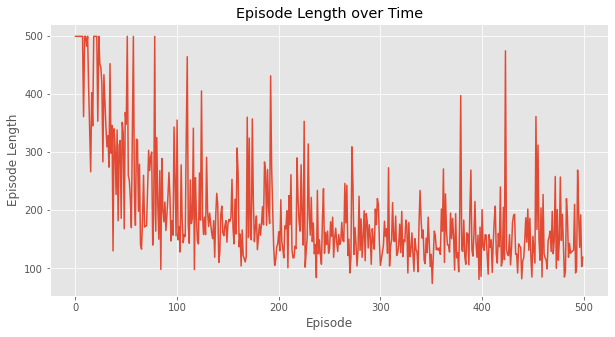

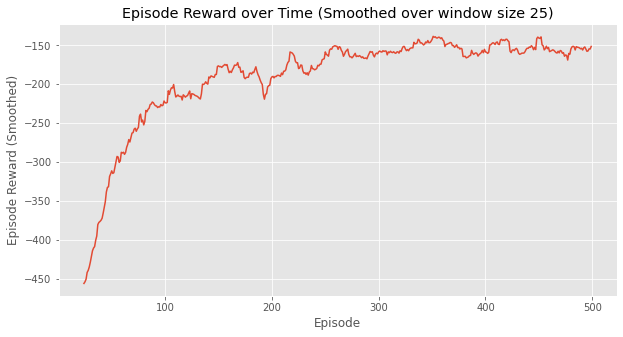

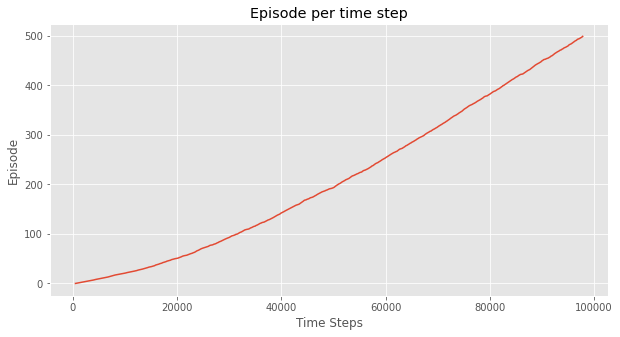

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [43]:
plotting.plot_episode_stats(stats, smoothing_window=25)

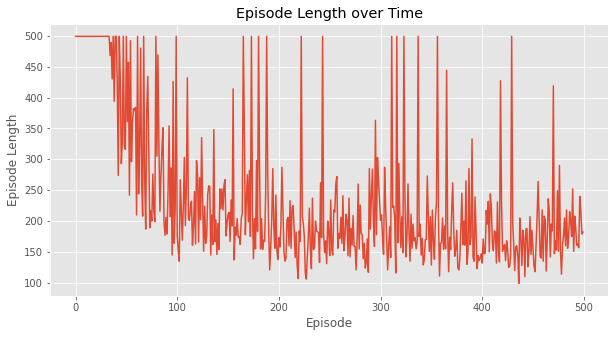

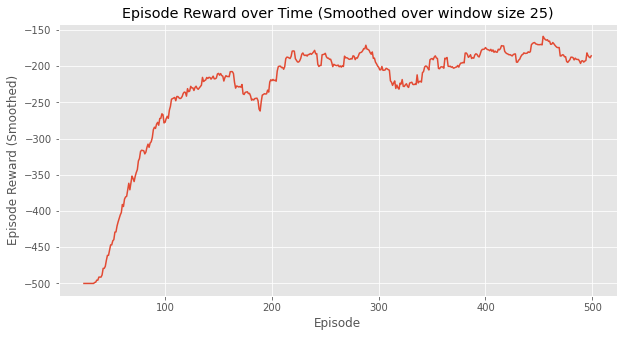

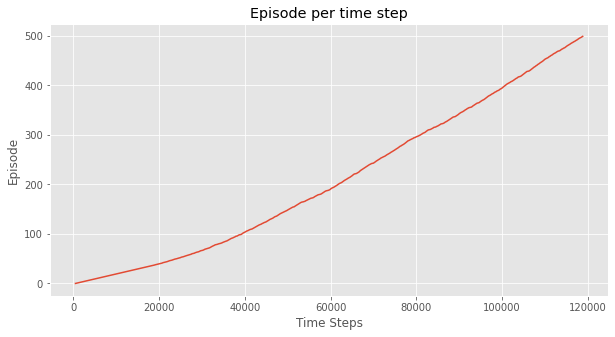

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats, smoothing_window=25)

In [17]:
# state = env.observation_space.sample()
state = env.reset()
# plt.figure()
# plt.imshow(env.render(mode='rgb_array'))
while True:
    q_values = estimator.predict(state)
    best_action = np.argmax(q_values)
#     plt.figure()
#     plt.imshow(env.render(mode='rgb_array'))

#     action_pge = get_pge_action(best_action)
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
# env.close()

In [63]:
env.observation_space.sample()

array([-0.11945403,  0.29413375, -1.4568335 , -0.17493604,  0.40899193,
        0.73602676,  1.3300323 ,  0.1892223 ], dtype=float32)

In [31]:
env = gym.make('CartPole-v1')

In [61]:
env.reset()
env.step(env.action_space.sample())

(array([ 0.00353907,  0.19214232, -0.0343606 , -0.34522076]), 1.0, False, {})

In [123]:
env.step(env.action_space.sample())

(array([-0.74117499, -1.35688824,  0.28442935,  1.79704102]), 0.0, True, {})

In [39]:
env.step(0)

(array([ 0.99191838,  0.12687758,  0.93816387, -0.34619151, -0.26319339,
         0.28025021]),
 -1.0,
 False,
 {})

In [40]:
env.close()